In [1]:
from utils import *
from SolarFlareNet_test import *

In [2]:
Window = [24]
Class = ["M"]
feature_names = 'TOTUSJH,TOTUSJZ,USFLUX,TOTBSQ,R_VALUE,TOTPOT,SAVNCPP,AREA_ACR,ABSNJZH'.split(',')

In [3]:
from PIL import Image

def combine_images(columns, space, images, fname):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    background.save('%s' %fname)

In [4]:
"""#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to train.
print('Loading the train_model function...')
from SolarFlareNet_train import *
for time_window in Window:
    for flare_class in Class:
        train(str(time_window), flare_class)
        log('===========================================================\n\n',verbose=True)"""

"#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.\n#You change the values to limit the flare types and number of hours to train.\nprint('Loading the train_model function...')\nfrom SolarFlareNet_train import *\nfor time_window in Window:\n    for flare_class in Class:\n        train(str(time_window), flare_class)\n        log('===========================================================\n\n',verbose=True)"

In [5]:
#Dependencies
#!pip install lime (to run LIME)
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython (to run ALE)
#!pip install alibi[ray] (to run ALE)
#!pip install shap (to run SHAP)
#!pip install timeshap (to run SHAP)

from lime.lime_tabular import RecurrentTabularExplainer
import shap
from shap import DeepExplainer
import timeshap
from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level
from timeshap.plot import plot_temp_coalition_pruning, plot_event_heatmap, plot_feat_barplot, plot_cell_level
from alibi.explainers import KernelShap
from alibi.explainers import ALE, plot_ale
from alepython import ale_plot
import matplotlib.pyplot as plt
import seaborn as sb

Python version: 3.11.5
Tensorflow bakcend version: 2.14.0

[2023-11-20 13:42:27] Testing is initiated for time_window: 24 and flare class: M 
[2023-11-20 13:42:27] loading data from file: data/training_data_M_24.csv 
[2023-11-20 13:42:29] loading data from file: data/testing_data_M_24.csv 
[2023-11-20 13:42:30] Loading weights from model dir: interpret_models/24/M 
[2023-11-20 13:42:30] Predicting test data set samples.. 
[2023-11-20 13:42:33] Saving result to file: result/SolarFlareNet/M_24.csv 
[2023-11-20 13:42:33] ===========================================================

 
Interpreting using ALE method


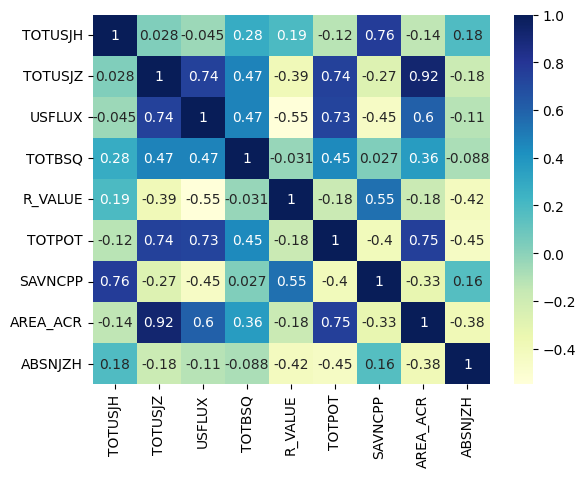

SystemExit: 

In [6]:
#Test existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to test.

# You change the tools listed in the interpretable_tools dict for using a specific tool to interpret
# LIME key takes a list of instances or a slice which consideres instances upto that range (i.e. example [:1000])
# ALE key takes a list containg types of plot we want. ["1D", "2D"]
# SHAP tool is not yet implemented.

interpretable_tools = {"LIM":[[2], slice(5)], "ALE":["1Dh", "2D"], "SHA":3}
tool_fn = lambda x: print("Interpreting using %s method" %x)
limit = 10000
top_features = []

for time_window in Window:
    for flare_class in Class:
        model, train_data, test_data = test(str(time_window), flare_class)
        X_train, y_train, X_test, y_test = train_data[0][:limit], train_data[1][:limit], test_data[0][:limit], test_data[1][:limit]
        #model.summary()
        log('===========================================================\n\n',verbose=True)
        for tool in interpretable_tools:
            if tool == "LIME":
                tool_fn(tool)
                model_mask = model.get_model()
                explainer = RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=feature_names,
                                                    discretize_continuous=True, verbose=False, feature_selection='none',
                                                    class_names=['Negative', 'Positive'], discretizer='decile')
                instances = interpretable_tools[tool]
                for instance in instances:
                    if isinstance(instance, list):
                        for i in instance:
                            exp = explainer.explain_instance(X_test[i], model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp.show_in_notebook()
                            #exp.as_pyplot_figure()
                            #exp.save_to_file(file_path="interpret/%s_%d.html" %(flare_class,time_window))
                    elif isinstance(instance, slice):
                        feature_rank = {x:[] for x in feature_names}
                        for data in X_test[instance]:
                            exp = explainer.explain_instance(data, model_mask.predict, num_features=len(feature_names), num_samples=5000)
                            exp_map = exp.as_map()
                            for k, rank in enumerate(exp_map[1]):
                                feature_rank[feature_names[rank[0]]].append(k+1)
                        feature_rank = pd.DataFrame(feature_rank)
                        final_ranking = feature_rank.mean().sort_values()
                        print(final_ranking)
                        ranking = final_ranking.to_dict()
            elif tool == "ALE":
                tool_fn(tool)
                plot_type = interpretable_tools[tool]
                w_dir = 'interpret_models' +os.sep + str(time_window) + os.sep + str(flare_class)
                path_fn_2D = tool_fn = lambda x: "ALE_plots" + os.sep + plot_type + os.sep + "%d_%s" %(time_window, flare_class) + os.sep + "%s.png" %x
                for type in plot_type:
                    if type == "1D":
                        ale = ALE(model.predict, feature_names=feature_names, target_names=["Label"])
                        ale_exp = ale.explain(np.squeeze(X_test)[:50000], min_bin_points=20)
                        plot_ale(ale_exp, n_cols=3, fig_kw={'figwidth':14, 'figheight': 10})
                    elif type == "2D":
                        X_train_df = pd.DataFrame(np.squeeze(X_test)[:50], columns=feature_names)
                        corr = X_train_df.corr(method='kendall')
                        sb.heatmap(corr, cmap='YlGnBu', annot=True)
                        plt.show()
                        sys.exit()
                        plt.rc("figure", figsize=(8,6))
                        figures = []
                        for i, f1 in enumerate(feature_names):
                            for f2 in feature_names[i:]:
                                if f1 != f2:
                                    ax = ale_plot(model, X_train_df, [f1,f2], bins=10, monte_carlo=True)
                                    fig = ax.get_figure()
                                    figures += [path_fn_2D("%s_%s" %(f1,f2))]
                                    fig.savefig(path_fn_2D("%s_%s" %(f1,f2)))
                        combine_images(6, 0, figures, path_fn_2D("%d_%s" %(time_window, flare_class)))
            elif tool == "SHAP":
                tool_fn(tool)
                model_mask = model.get_model()
                instance = interpretable_tools[tool]

                explainer = DeepExplainer(model_mask, X_train)
                shap_values = explainer.shap_values(X_test[(instance-1):instance], check_additivity=False)
                expected_value = explainer.expected_value
                shap.plots.initjs()
                display(shap.decision_plot(expected_value[0], shap_values[0][0], feature_names))
                display(shap.force_plot(expected_value[0], shap_values[0][0], feature_names=feature_names, 
                                        matplotlib=True, contribution_threshold=0.005))
                
                """predict_fn = lambda x: model.predict(x)
                explainer = KernelShap(predict_fn, link='logit', feature_names=feature_names)
                explainer.fit(np.squeeze(X_train[:5000]))
                explanation = explainer.explain(np.squeeze(X_test)[(instance-1):instance])"""
                
                
                